In [46]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

#Read Data

In [18]:
with open('../Data/train_arrays_1.pickle', 'rb') as handle:
  train_matrix = pickle.load(handle)
with open('../Data/test_arrays_1.pickle', 'rb') as handle:
  test_matrix = pickle.load(handle)

In [41]:
train_y = []
test_y = []
with open('../Data/allans_forDL.csv') as alldata:
    for line_no, line in enumerate(alldata):
        tags, words_texts, split, sentiment = line.strip().split('\t')
        if split=='train':
            if sentiment == "good":
                train_y.append(1)
            else:
                train_y.append(0)
        else:
            if sentiment == "bad":
                test_y.append(1)
            else:
                test_y.append(0)

In [42]:
y_train = np.array(train_y)
y_test = np.array(test_y)

In [55]:
with open('../Data/train_label.pickle', 'wb') as handle:
  pickle.dump(y_train,handle)
with open('../Data/test_label.pickle', 'wb') as handle:
  pickle.dump(y_test,handle)

In [15]:
train_matrix.shape

(44598, 100)

In [19]:
test_matrix.shape

(29733, 100)

#Logistics Model

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [23]:
num_folds = 10
num_instances = len(train_matrix)
seed = 7

In [32]:
# Spot-Check Algorithms
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' ,
    LogisticRegression(n_jobs=-1))])))
pipelines.append(( 'ScaledKNN' , Pipeline([( 'Scaler' , StandardScaler()),( 'KNN' ,
    KNeighborsClassifier(n_jobs=-1))])))
pipelines.append(( 'ScaledCART' , Pipeline([( 'Scaler' , StandardScaler()),( 'CART' ,
    DecisionTreeClassifier())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVM' , SVC())])))

In [44]:
results = []
names = []
for name, model in pipelines:
  kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
  cv_results = cross_validation.cross_val_score(model, train_matrix, y_train, cv=kfold,
      scoring='f1')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: 0.649331 (0.042351)
ScaledKNN: 0.541689 (0.041568)
ScaledCART: 0.557903 (0.047976)
ScaledSVM: 0.642305 (0.038071)


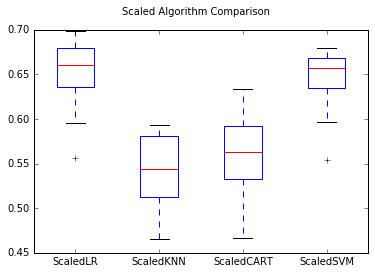

In [47]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( 'Scaled Algorithm Comparison' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#Tuning parameter for Logistics models

In [50]:
scaler = StandardScaler().fit(train_matrix)
rescaledX = scaler.transform(train_matrix)
C = [0.001, 0.01, 0.1, 1, 5, 10, 20]
param_grid = dict(C=C)
model = LogisticRegression(n_jobs=-1)
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.595968 using {'C': 0.01}
0.595922 (0.023312) with: {'C': 0.001}
0.595966 (0.024583) with: {'C': 0.01}
0.595877 (0.024902) with: {'C': 0.1}
0.595899 (0.024903) with: {'C': 1}
0.595899 (0.024903) with: {'C': 5}
0.595899 (0.024903) with: {'C': 10}
0.595899 (0.024903) with: {'C': 20}


#Ensembling Models

In [ ]:
# ensembles
ensembles = []
ensembles.append(( 'AB' , AdaBoostClassifier()))
ensembles.append(( 'GBM' , GradientBoostingClassifier()))
ensembles.append(( 'RF' , RandomForestClassifier()))
ensembles.append(( 'ET' , ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
  kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
  cv_results = cross_validation.cross_val_score(model, train_matrix, y_train, cv=kfold,
      scoring = 'f1')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

In [ ]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( Ensemble Algorithm Comparison )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#Finalize Model 

In [ ]:
#prepare the model
scaler = StandardScaler().fit(train_matrix)
rescaledX = scaler.transform(train_matrix)
model = LogisticRegression(n_jobs=-1,C=1)
model.fit(rescaledX, y_train)
#estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(test_matrix)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))